# VRP GraphNet

model inputs from the paper:

| Variable             | Meaning                           | Dimensions                |
|----------------------|-----------------------------------|---------------------------|
| batch_edges          | Adj matrix special connections*   | B x num_nodes x num_nodes |
| batch_edges_values   | Distance Matrix                   | B x num_nodes x num_nodes |
| batch_edges_target   | Target adj matrix                 | B x num_nodes x num_nodes |
| batch_nodes          | Ones vector                       | B x num_nodes             |
| batch_nodes_coord    | Coordinates                       | B x num_nodes x 2         |
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes             |


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [ ]:
try:
    from google.colab import drive

    drive.mount('/content/gdrive')

    %cd gdrive/My Drive/machine-learning-course
    %pip install -r requirements-colab.txt
    %load_ext tensorboard
    %tensorboard --logdir runs
    IN_COLAB = True
except:
    IN_COLAB = False

In [437]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from model import GraphNet
from utils import load_config, get_metrics, get_device, load_checkpoint, save_checkpoint
from utils.data import load_and_split_dataset, process_datasets, sparse_matrix_from_routes, distance_from_sparse_matrix

sns.set_theme()

## Load datasets

In [664]:
dsets = load_and_split_dataset("data/tsp_20_3s.pkl", test_size=1000)
train_dataset, test_dataset = process_datasets(dsets, k=3)

print(len(train_dataset), len(test_dataset))

(310, 4)

In [ ]:
edge_class_weights = train_dataset.class_weights()
edge_class_weights

## Basic Config

In [31]:
device = get_device()
print("Device", device)

Device cpu


In [32]:
default_config = load_config(hidden_dim=32, num_gcn_layers=5, num_mlp_layers=3,
                             learning_rate=0.001, train_batch_size=64, test_batch_size=64, num_epochs=50)
default_config

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=default_config.train_batch_size,
                              shuffle=True)

model = GraphNet(default_config).to(device)

Experiment: vrp_20_k3_normalized_32_hidden_dim


## Test Forward Pass

In [351]:
features, _ = next(iter(train_dataloader))

y_pred = model.forward(features["node_features"].to(device),
                       features["dist_matrix"].to(device),
                       features["edge_feat_matrix"].to(device))

y_pred.shape

torch.Size([64, 21, 21, 2])

## Validation loop

In [41]:
def greedy_tour_lengths(y_preds, batch_dist_matrix):
    # only keep the probability of selecting the edge
    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(y_preds, beam_width=1, num_vehicles=1)
    beamsearch.search()

    # get most probable tours (index = 0)
    tours = beamsearch.get_beam(0)

    sp_targets = sparse_matrix_from_routes(tours, batch_dist_matrix.size(-1))
    tour_lengths = distance_from_sparse_matrix(sp_targets, batch_dist_matrix)

    return tour_lengths, tours


def shortest_tour_lengths(y_preds, batch_dist_matrix, beam_width=1024):
    # only keep the probability of selecting the edge
    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(y_preds, beam_width=beam_width, num_vehicles=1)
    beamsearch.search()

    shortest_tours = torch.zeros((batch_dist_matrix.size(0), len(beamsearch.next_nodes)))
    shortest_tour_distances = torch.full((batch_dist_matrix.size(0),), np.inf)

    for i in range(beamsearch.beam_width):
        tours = beamsearch.get_beam(i)

        # creating the sparse matrix is expensive
        sp_adj_matrix = sparse_matrix_from_routes(tours, batch_dist_matrix.size(-1))
        tour_lengths = distance_from_sparse_matrix(sp_adj_matrix, batch_dist_matrix)

        # keep the shortest tours
        condition = torch.lt(tour_lengths, shortest_tour_distances).unsqueeze(-1)
        shortest_tours = torch.where(condition, tours, shortest_tours)

        # keep the shortest tour lengths
        shortest_tour_distances = torch.minimum(shortest_tour_distances, tour_lengths)

    return shortest_tour_distances, shortest_tours


def eval_model(batch_node_features, batch_dist_matrix, batch_edge_features, model):
    model.eval()

    with torch.no_grad():
        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
        preds = F.softmax(preds, dim=3)

        return preds


def validate(dataloader, model, criterion):
    running_tour_lengths = 0
    running_loss = 0
    targets = []
    predictions = []

    for batch_features, batch_targets in dataloader:
        batch_node_features = batch_features["node_features"].to(device)
        batch_dist_matrix = batch_features["dist_matrix"].to(device)
        batch_edge_features = batch_features["edge_feat_matrix"].to(device)
        batch_targets = batch_targets.to(device)

        y_preds = eval_model(batch_node_features, batch_dist_matrix, batch_edge_features,
                             model=model)

        # Loss
        loss = get_loss(y_preds, batch_targets, criterion)
        running_loss += loss.item()

        # Tour lengths (mean per batch)
        tour_lengths, _ = greedy_tour_lengths(y_preds.cpu(), batch_dist_matrix.cpu())
        running_tour_lengths += tour_lengths.mean()

        y_preds = y_preds.argmax(dim=3)
        y_preds = y_preds.cpu().numpy()

        targets.append(batch_targets.cpu().numpy())
        predictions.append(y_preds)

    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
    mean_running_loss = running_loss / len(dataloader)
    mean_running_tour_length = running_tour_lengths / len(dataloader)

    return targets, predictions, mean_running_loss, mean_running_tour_length

## Training Loop

In [42]:
def get_loss(preds, targets, criterion):
    preds_perm = preds.permute(0, 3, 1, 2)

    return criterion(preds_perm, targets)


def train_one_epoch(dataloader, model, optimizer, criterion):
    running_loss = 0

    model.train()

    for batch_idx, (batch_features, batch_targets) in enumerate(dataloader):
        optimizer.zero_grad()

        batch_node_features = batch_features["node_features"].to(device)
        batch_dist_matrix = batch_features["dist_matrix"].to(device)
        batch_edge_features = batch_features["edge_feat_matrix"].to(device)
        batch_targets = batch_targets.to(device)

        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
        loss = get_loss(preds, batch_targets, criterion)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    return running_loss


def train(num_epochs, train_dl, test_dl, model, optimizer, criterion, writer):
    best_loss = np.inf

    for epoch in range(num_epochs):
        # Train
        running_loss = train_one_epoch(train_dl, model=model, optimizer=optimizer, criterion=criterion)

        # Losses
        epoch_loss = running_loss / len(train_dl)

        # Validation Metrics
        targets, predictions, validation_loss, tour_length = validate(test_dl, model=model, criterion=criterion)
        metrics = get_metrics(targets, predictions)

        writer.add_scalar("Metrics/accuracy", metrics.acc, epoch)
        writer.add_scalar("Metrics/bal. accuracy", metrics.bal_acc, epoch)
        writer.add_scalar("Metrics/precision", metrics.precision, epoch)
        writer.add_scalar("Metrics/recall", metrics.recall, epoch)
        writer.add_scalar("Metrics/f1 score", metrics.f1_score, epoch)
        writer.add_scalar("Metrics/tour length", tour_length, epoch)

        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/test", validation_loss, epoch)

        # Save (validation) checkpoint
        if validation_loss < best_loss:
            best_loss = validation_loss
            save_checkpoint(writer.log_dir / "best_validation_loss_model.pt",
                            model=model, optimizer=optimizer,
                            epoch=epoch, config={**config}, train_loss=epoch_loss, test_loss=validation_loss)

        # Save (epoch) checkpoint
        save_checkpoint(writer.log_dir / "last_epoch_model.pt",
                        model=model, optimizer=optimizer,
                        epoch=epoch, config={**config}, train_loss=epoch_loss, test_loss=validation_loss)

        print(f'Epoch: {epoch:02d}, Loss: {epoch_loss:.4f}')

## Baseline Model

In [43]:
LOG_DIR = Path("runs/exp_baseline")

config = load_config(**default_config)

train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.test_batch_size, shuffle=True)

torch.manual_seed(0)

edge_class_weights = train_dataset.class_weights().to(device)
model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss(edge_class_weights)

writer = SummaryWriter(log_dir=LOG_DIR)

train(config.num_epochs, train_dl=train_dataloader, test_dl=test_dataloader,
      model=model, optimizer=optimizer, criterion=criterion, writer=writer)
writer.flush()
writer.close()

Epoch: 00, Loss: 0.3330
Epoch: 01, Loss: 0.2783
Epoch: 02, Loss: 0.2665
Epoch: 03, Loss: 0.2587
Epoch: 04, Loss: 0.2532
Epoch: 05, Loss: 0.2492
Epoch: 06, Loss: 0.2459
Epoch: 07, Loss: 0.2427
Epoch: 08, Loss: 0.2400
Epoch: 09, Loss: 0.2372
Epoch: 10, Loss: 0.2350
Epoch: 11, Loss: 0.2330
Epoch: 12, Loss: 0.2310
Epoch: 13, Loss: 0.2300
Epoch: 14, Loss: 0.2284
Epoch: 15, Loss: 0.2273
Epoch: 16, Loss: 0.2259
Epoch: 17, Loss: 0.2251
Epoch: 18, Loss: 0.2240
Epoch: 19, Loss: 0.2232


## Validating model results

In [808]:
from utils.beam_search import BeamSearch

In [809]:
testset = dataset.test

targ = dataset.test[0][1]
num_vehicles = int(targ[0].cpu().numpy().sum() / 2)

num_vehicles

3

In [810]:
targ = targ.unsqueeze(0)
targ.shape

torch.Size([1, 21, 21])

In [811]:
beamsearch = BeamSearch(targ, beam_width=1, num_vehicles=num_vehicles, allow_consecutive_depot_visits=False)

for i in range(1, 6):
    print(f"Step {i}")
    print("Next nodes:", beamsearch.current_nodes[0, 0])
    print("Mask:", beamsearch.mask[0, 0])
    print()
    beamsearch.step()

Step 1
Next nodes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Mask: tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

Step 2
Next nodes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
Mask: tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

Step 3
Next nodes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Mask: tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

Step 4
Next nodes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
Mask: tensor([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

Step 5
Next nodes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Mask: tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])



In [812]:
dataset.test.data[0]['routes']

{0: [13, 9, 2, 17, 19, 7, 20, 14],
 1: [5, 16, 18, 6, 1, 10, 12],
 2: [11, 4, 3, 15, 8],
 3: [],
 4: []}

In [813]:
count = 0
for i in range(len(dataset.test)):
    d = dataset.test.data[i]
    for path in d['routes'].values():
        if len(path) == 1:
            count += 1
            print(d['routes'])
count, len(testset)

{0: [10, 19, 9, 4, 16, 17], 1: [11, 1, 7, 20, 12, 5], 2: [13], 3: [6, 8, 15, 14, 3, 2, 18], 4: []}
{0: [], 1: [13, 15, 6, 17, 11, 5, 9, 4], 2: [16, 3, 12, 1, 10], 3: [14], 4: [2, 20, 8, 7, 18, 19]}
{0: [5], 1: [8, 17, 19, 6, 7, 13, 20], 2: [14, 15, 18, 16, 3, 1, 12], 3: [2, 10, 11, 4, 9], 4: []}


(3, 200)

### Findings

Beam search should disallow visiting the depot if it just came from there (thus it should be disabled for two steps). However there are three exepections in the testset for which this would be a problem. The stable sort property should actually allow for this, or add a small probability to always allow going back to the depot.

But this isn't relevant when taking the cluster-first, route second approach.

In [814]:
vehicles_required = np.array([], dtype=int)

for (_, targets) in testset:
    # ceil because when there is only one node, the out_paths become uneven
    paths_out = np.ceil(targets[0].cpu().numpy().sum() / 2)

    vehicles_required = np.append(vehicles_required, paths_out)

np.unique(vehicles_required)

array([2., 3., 4.])

In [815]:
def get_clustering(num_nodes, routes):
    clusters = np.full(num_nodes, 0)

    for c, path in routes.items():
        for p in path:
            clusters[p - 1] = c

    return clusters

In [816]:
# TODO: Some of this information should be part of the pickled dataset

l = len(testset)

batch_node_features = np.empty((l, 21, 3))
batch_dist_matrix = np.empty((l, 21, 21))
batch_edge_types = np.empty((l, 21, 21))
batch_targets = np.empty((l, 21, 21))

batch_vehicles_count = np.array(vehicles_required, dtype=int)  # TODO: add to dataset
batch_clusters = np.empty((l, 20))  # TODO: add to dataset

for i in range(len(testset)):
    data = testset.data[i]

    batch_node_features[i] = data['node_features']
    batch_dist_matrix[i] = data['dist_matrix']
    batch_edge_types[i] = data['edge_feat_matrix']
    batch_targets[i] = data['target']
    batch_clusters[i] = get_clustering(20, data['routes'])

In [817]:
batch_preds = eval_model(torch.tensor(batch_node_features, dtype=torch.float32),
                         torch.tensor(batch_dist_matrix, dtype=torch.float32),
                         torch.tensor(batch_edge_types, dtype=torch.int32))

batch_preds = batch_preds.softmax(dim=3)
batch_preds_argmax = batch_preds.argmax(dim=3)
batch_preds = batch_preds[..., 1]

### Clustering validation

In [818]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import adjusted_rand_score

In [879]:
# TODO: The clusterings and violations should be checked in the training loop after ever epoch
scores = np.empty((l, 4))
clusters = np.empty((l, 4, 20))

for i, ground_truth in enumerate(batch_clusters):
    # ignore the depot
    dist_mat = batch_dist_matrix[i]
    preds = batch_preds_less[i]
    coords = batch_node_features[i, :, :2]

    num_vehicles = int(batch_vehicles_count[i])

    inv_dist_mat = np.linalg.inv(dist_mat)
    rec_dist_mat = np.reciprocal(dist_mat)

    np.fill_diagonal(rec_dist_mat, 0)

    sc = SpectralClustering(num_vehicles, affinity="precomputed", assign_labels="cluster_qr")
    kmeans = KMeans(num_vehicles, n_init=10, init="k-means++")

    a = sc.fit_predict(inv_dist_mat)
    b = sc.fit_predict(rec_dist_mat)
    c = sc.fit_predict(preds)
    d = kmeans.fit_predict(coords)

    _temp = []
    _clusters = []
    for cl in (a, b, c, d):
        _clusters.append(cl[1:])
        _temp.append(adjusted_rand_score(ground_truth, cl[1:]))

    scores[i] = _temp
    clusters[i] = _clusters

Mean: [0.4565736  0.39192628 0.47067783 0.47304896]


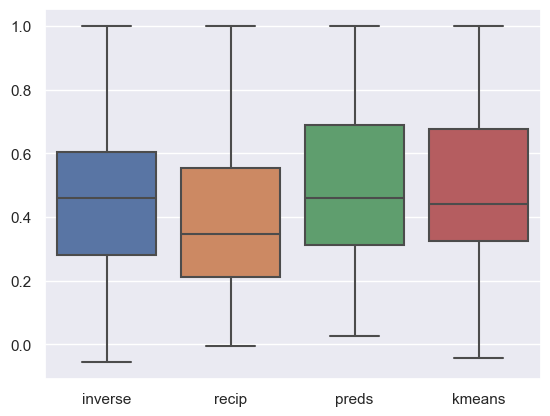

In [880]:
labels = ["inverse", "recip", "preds", "kmeans"]

print("Mean:", np.mean(scores, axis=0))
sns.boxplot(y=scores.T.flatten(),
            x=np.repeat([1, 2, 3, 4], scores.shape[0])).set_xticks(range(4), labels=labels)
plt.show()

In [881]:
def cluster_loads(clustering, demands):
    clusters = np.unique(clustering)
    loads = np.zeros_like(clusters)

    for i, cl in enumerate(clusters):
        loads[i] = demands[clustering == cl].sum()

    return loads


def count_cluster_violations(clusters, demands):
    violations = np.zeros(clusters.shape[0])

    for i, (cluster, demand) in enumerate(zip(clusters, demands)):
        load = cluster_loads(cluster, demand)
        # round to fix floating point errors
        violations[i] = np.sum(load.round(4) > 1)

    return violations

In [882]:
violations = [count_cluster_violations(clusters[:, i], batch_node_features[:, 1:, 2]).sum() for i in
              range(clusters.shape[1])]
violations

[142.0, 171.0, 153.0, 150.0]

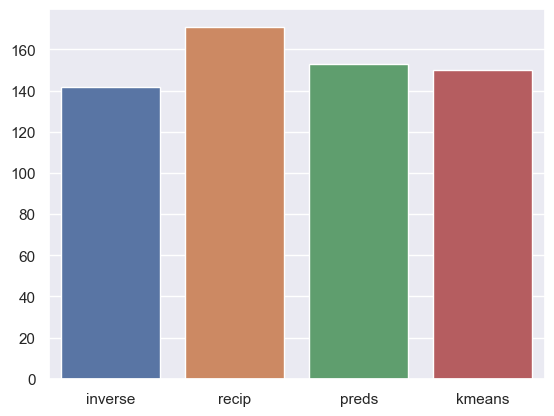

In [883]:
sns.barplot(x=np.arange(len(violations)), y=violations).set_xticks(range(len(labels)), labels=labels)
plt.show()

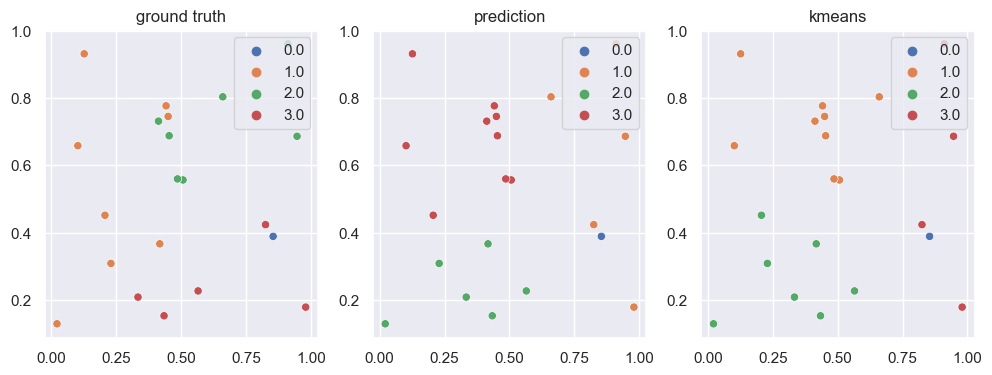

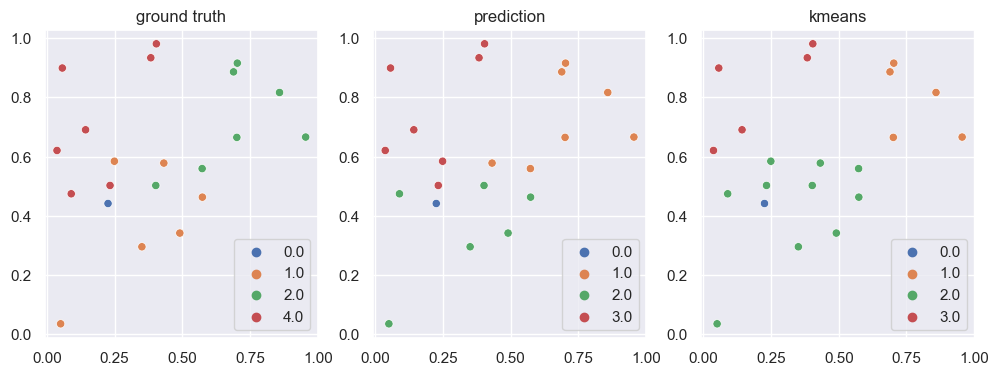

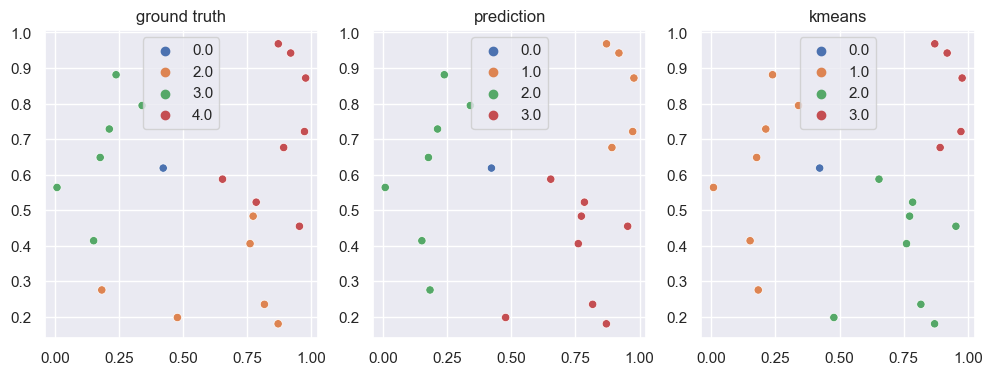

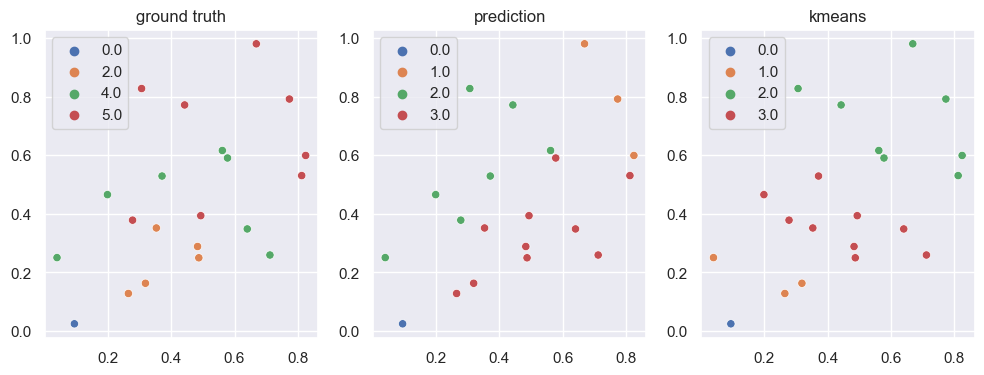

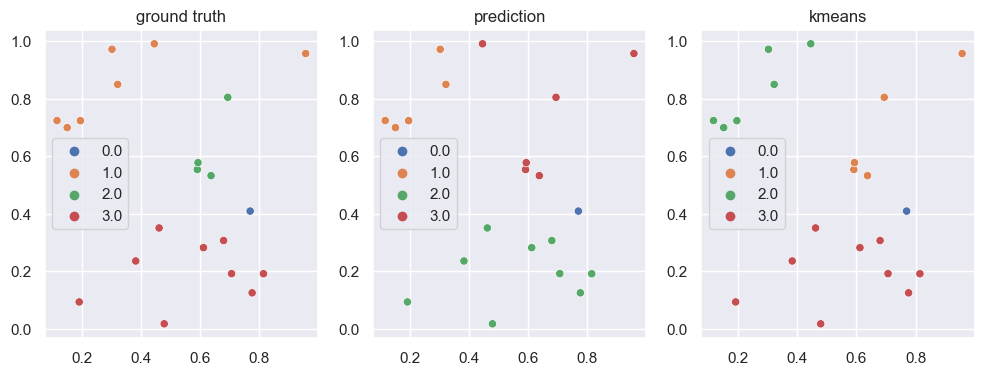

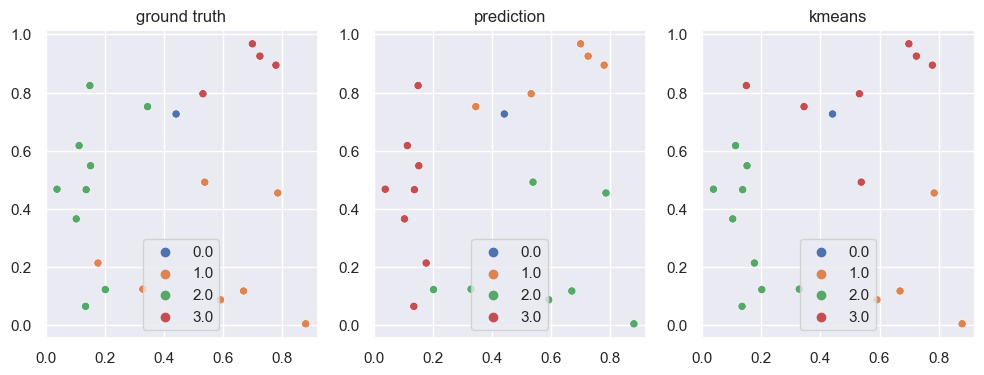

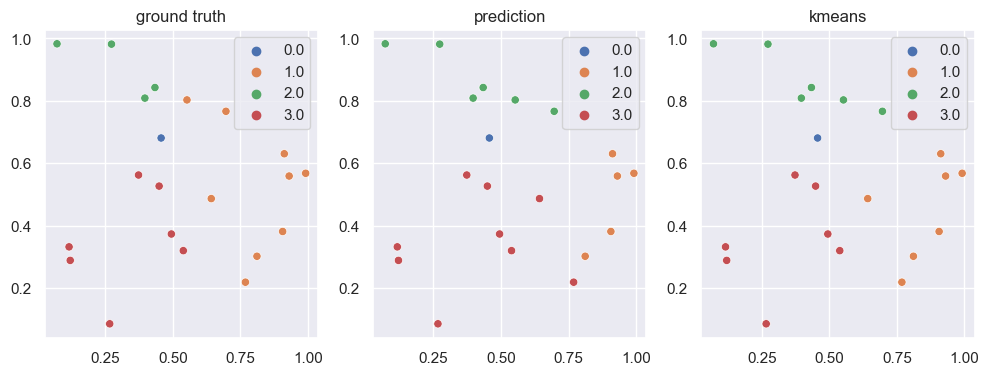

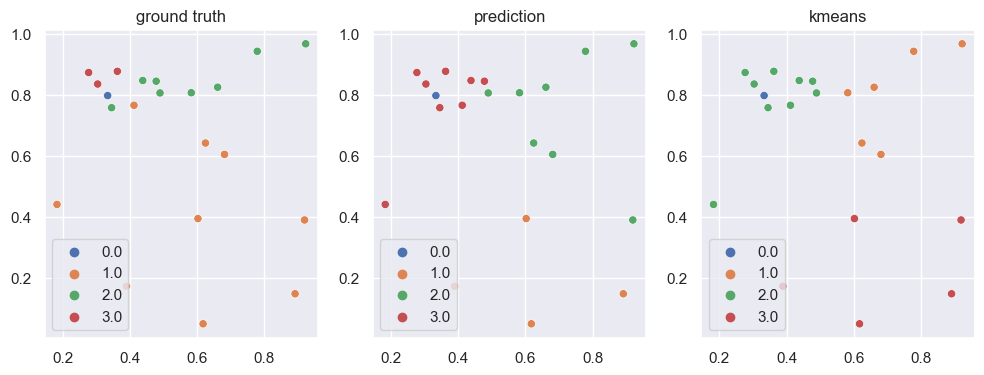

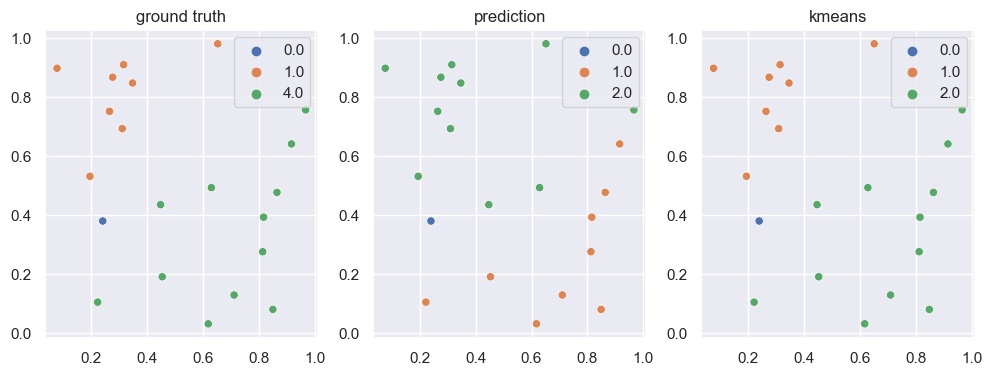

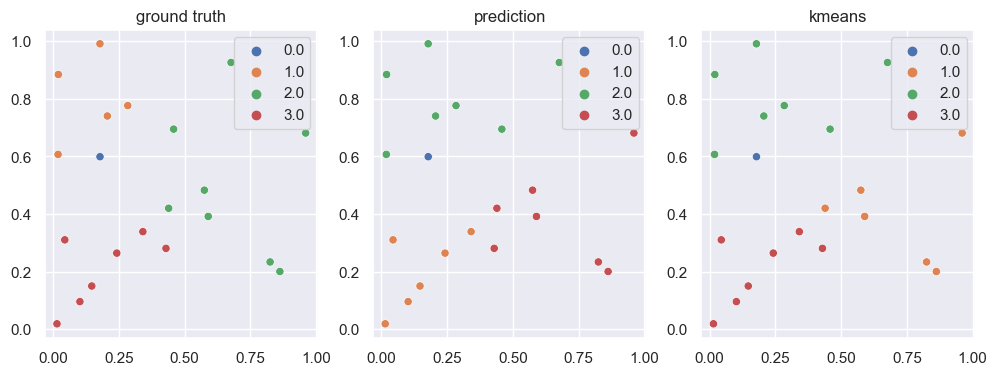

In [884]:
for i in range(10):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.scatterplot(x=batch_node_features[i, :, 0], y=batch_node_features[i, :, 1], ax=axes[0],
                    hue=np.concatenate(([0], batch_clusters[i] + 1)), palette="deep")
    sns.scatterplot(x=batch_node_features[i, :, 0], y=batch_node_features[i, :, 1], ax=axes[1],
                    hue=np.concatenate(([0], clusters[i, 2] + 1)), palette="deep")
    sns.scatterplot(x=batch_node_features[i, :, 0], y=batch_node_features[i, :, 1], ax=axes[2],
                    hue=np.concatenate(([0], clusters[i, 3] + 1)), palette="deep")
    axes[0].set_title("ground truth")
    axes[1].set_title("prediction")
    axes[2].set_title("kmeans")

    plt.show()

In [877]:
batch_preds_less = torch.clone(batch_preds)
batch_preds_less[batch_preds_less < 1e-4] = 0

### Findings

Using the reciprocal distance matrix doesn't produce good results. K-means and inverse distance matrix are comparable while the latter generally performs better.

Using the `cluster_qr` produces better results for the predictions generally. The problem with the k-means algorithm is that it is dependant on the initial random configuration, so the results may vary. Ideally we would like to see a much lower number in terms of the cluster violations.

I'm not sure if `SpectralClustering` is the right one for the job

## Plot the results

In [376]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []

    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row > 0).flatten()
        src = np.full(dest.size, i)

        adj_list.extend(zip(src, dest))

    return adj_list


def plot_edge_predictions(features, pred, target, ax=None):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(features[:, :2]))
    demands = dict(enumerate(features[:, 2]))

    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos, with_labels=True)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3, ax=ax)


def get_over_threshold(preds, threshold):
    pred = np.copy(preds)
    pred[preds >= threshold] = 1
    pred[preds < threshold] = 0

    return pred

0
{0: [13, 9, 2, 17, 19, 7, 20, 14], 1: [5, 16, 18, 6, 1, 10, 12], 2: [11, 4, 3, 15, 8], 3: [], 4: []}


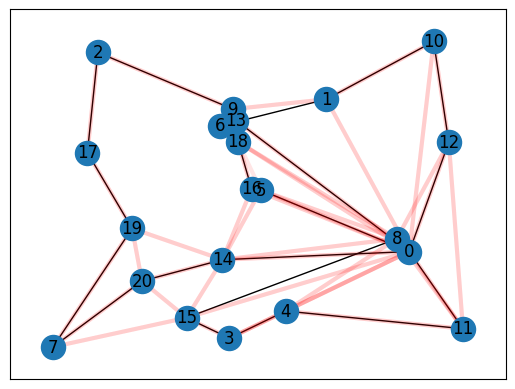

1
{0: [9, 14, 18, 2, 11, 7], 1: [19, 3, 6, 20, 1, 5, 15], 2: [], 3: [10, 17, 16, 13, 12, 4, 8], 4: []}


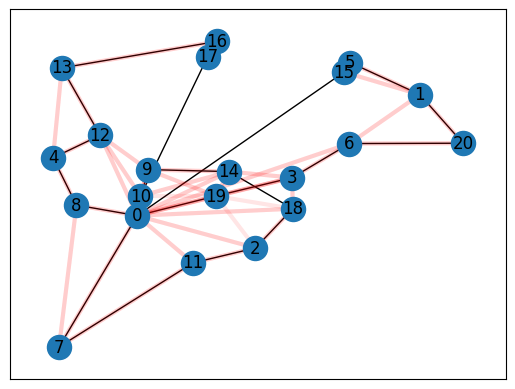

2
{0: [], 1: [8, 1, 7, 3, 15, 5], 2: [20, 14, 10, 18, 4, 6], 3: [19, 9, 11, 12, 16, 17, 2, 13], 4: []}


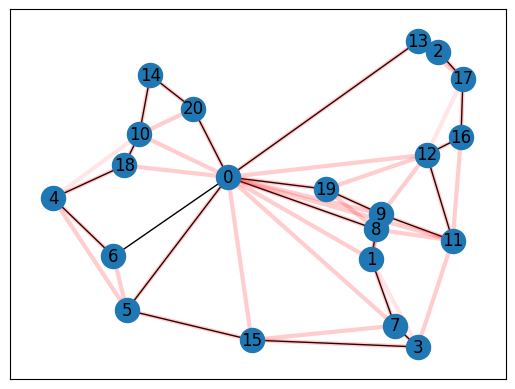

3
{0: [], 1: [6, 9, 14, 1, 12], 2: [], 3: [13, 7, 18, 15, 11, 17, 20], 4: [5, 8, 16, 2, 10, 19, 3, 4]}


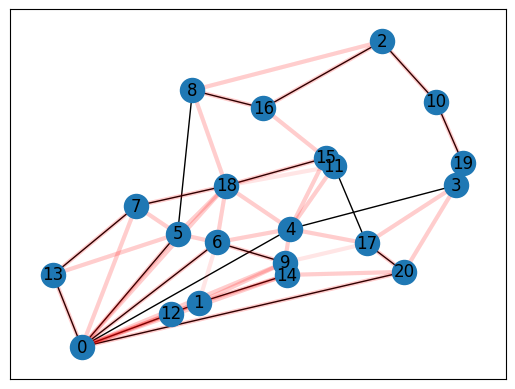

4
{0: [3, 2, 13, 4, 15, 8, 17], 1: [6, 10, 1, 11], 2: [9, 5, 18, 19, 12, 20, 16, 7, 14], 3: [], 4: []}


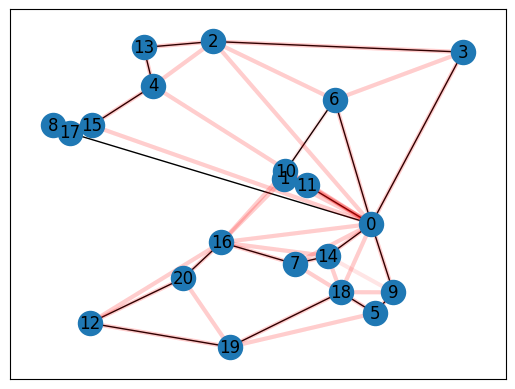

5
{0: [2, 16, 1, 17, 20, 19, 10], 1: [6, 11, 13, 5, 18, 8, 3, 4, 7], 2: [9, 14, 12, 15], 3: [], 4: []}


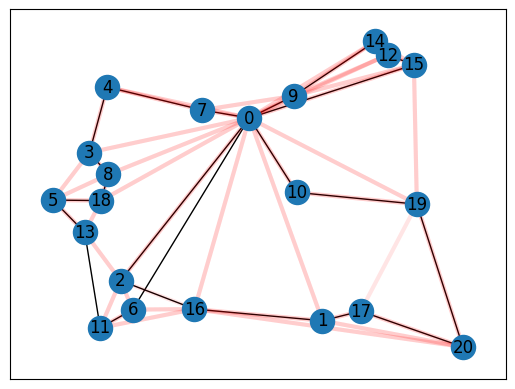

6
{0: [16, 20, 3, 6, 18, 15, 4, 5, 14], 1: [9, 11, 1, 19], 2: [12, 8, 7, 13, 2, 10, 17], 3: [], 4: []}


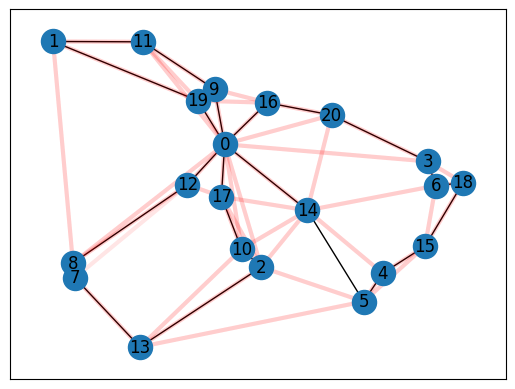

7
{0: [2, 18, 11, 8, 6, 7, 20, 15, 4], 1: [12, 19, 5, 1, 3, 14, 9, 10], 2: [13, 16, 17], 3: [], 4: []}


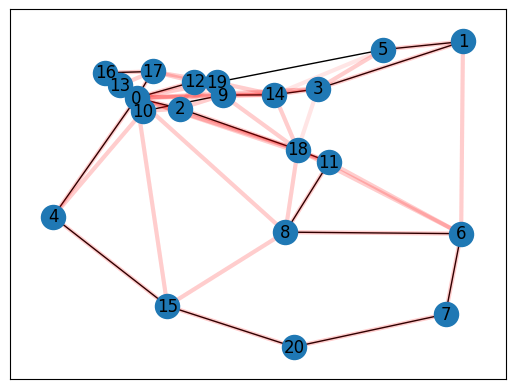

8
{0: [1, 17, 9, 18, 15, 3, 11, 6], 1: [], 2: [], 3: [5, 12, 4, 19, 8, 2, 14, 16, 7, 10, 13, 20], 4: []}


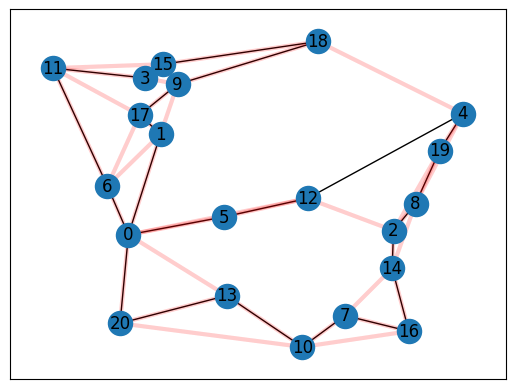

9
{0: [17, 5, 9, 13, 18], 1: [16, 1, 11, 15, 2, 12, 19, 10], 2: [14, 8, 3, 6, 7, 4, 20], 3: [], 4: []}


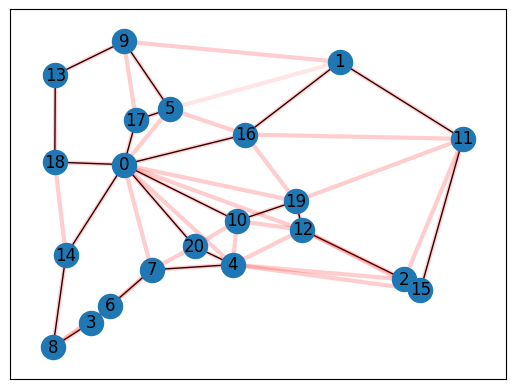

In [377]:
for i in range(10):
    plot_edge_predictions(batch_node_features[i],
                          batch_preds_argmax[i].cpu().numpy(),
                          batch_targets[i])
    print(i)
    print(testset.data[i]['routes'])
    plt.show()

## Findings

It seems like a lot of the wrong predictions are coming from the connections between the depot node and the nodes around it. There are cases where the correct nodes are not being predicted, perhaps because it's predicting a closer node.

Things to try:
* change edge type matrix - add connection between nodes and depot
* remove edge type matrix - give every edge the same value (1)
* adjust k-nn value